**Histórico das atas do COPOM**

* Atas: https://www.bcb.gov.br/publicacoes/atascopom/cronologicos

    * De janeiro/1998 até junho/2016, as atas não possuem o arquivo PDF formatado na mesma estrutura que existe atualmente;
    * A partir de julho/2016 até os dias de hoje, as atas são divulgadas em um arquivo PDF.

---

* Minutes: https://www.bcb.gov.br/en/publications/copomminutes/cronologicos

    * O número de atas publicadas em inglês é diferente das atas publicadas em português. A primeira ata publicada em inglês é de 01/2000;
    * Desde o começo das suas publicações em inglês, os arquivos já possuiam um arquivo PDF.


In [3]:
import requests
from bs4 import BeautifulSoup
import IPython
import re
import json
from time import sleep
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('bmh')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### **Funções** 

In [36]:
def minute_json(date_minute: str):
    """
    Realiza o web scraping das atas do COPOM.

    Parameters:
    date_minute (str): data de publicação no formato 'ddmmyyyy'.

    Returns:
    Objeto json do texto do COPOM.

    """
    url = f'https://www.bcb.gov.br/api/servico/sitebcb/copomminutes/principal?filtro=IdentificadorUrl%20eq%20%27{date_minute}%27'
        
    headers = {
        "authority": "www.bcb.gov.br",
        "accept": "application/json, text/plain, */*",
        "accept-language": "pt-BR,pt;q=0.9",
        "cookie": "TS01d9825e=012e4f88b36cce3651c602c46f3e3dcf2c6e53409aad20d4028657ad6c0ce74f163bd591ec1ebae4c2224d16a5510b53756786b3b0; dtLatC=1; dtPC=-; TS01c46804=012e4f88b3da9e1e50438b217c16cd55dd2e13e2ebe839f4e95c012790098b9fb734a1d9fab097738b4c355d9c8a444d65d548285629cdca0e66b95ab0bfd7ecc10387d2b4cc65a5e23ab422e6946c0e01e97c458a; dtCookie=v_4_srv_1_sn_1BEC291D8A0D6B90B90E0418D5AC1813_perc_100000_ol_0_mul_1_app-3Asgs_1_app-3A262a693a3e337a24_1^|c2dzfDE; dtSa=true^%^7CKD17^%^7C-1^%^7Ctexto^%^7C-^%^7C1693916845380^%^7C116732625_395^%^7Chttps^%^3A^%^2F^%^2Fwww3.bcb.gov.br^%^2Fsgspub^%^2Flocalizarseries^%^2FlocalizarSeries.do^%^3Fmethod^%^3DprepararTelaLocalizarSeries^%^7CSGS^%^20-^%^20Sistema^%^20Gerenciador^%^20de^%^20S^%^C3^%^A9ries^%^20Temporais^%^7C1693916734678^%^7C",
        "if-none-match": "W/^\^2bc4b976-98e8-41ba-97cc-ebf522d9a013^^",
        "referer": "https://www.bcb.gov.br/en/publications/copomminutes",
        "sec-ch-ua": "^\^Chromium^^;v=^\^116^^, ^\^Not"
    }

    r = requests.request("GET", url, headers=headers)
    data = r.json()

    # Título da ata -> '255th Meeting - June 20-21, 2023'
    titulo_minute = data['conteudo'][0]['Titulo']
    # Selecionando apenas o nº da ata
    num_minute = re.findall(r'(\d+)(?:st|nd|rd|th)', titulo_minute)[0]

    # Texto com elementos HTML (c/ elementos HTML) -> Exemplo: '<div id="atacompleta"><div id="ataconteudo"><h3 class="secao">A) Update of economic outlook and Copom’s scenario<sup>1</sup></h3><p class="paragrafo">1. 
    text_minute = data['conteudo'][0]['OutrasInformacoes']

    # Usando o BeautifulSoup para analisar o HTML
    soup = BeautifulSoup(text_minute, 'html.parser')
    # Extraindo o texto principal sem elementos HTML
    minute_text = soup.get_text()

    # Criando um dicionário com uma chave para o texto p/ transformar em um arquivo JSON
    dados = {f'minute_{num_minute}': minute_text}

    with open(f'C://Users//vitor//projetos_python//python_b3//nlp_copom_fomc//copom//minutes-json//minute_{num_minute}.json', 'w', encoding='utf-8') as arquivo_json:
        json.dump(dados, arquivo_json)
    
    sleep(2)


def minute_copom(text_minute: str):
    """
    Formatando o texto do minute em seis partes: completo, título 'A', título 'B', título 'C', título 'D' e notas do rodapé.
    Essa função irá função apenas da ata 246 até a mais atual.

    Parameters:
    text_minute: texto do minute publicado pelo BC.

    Returns:
    Dataframes do texto do minute (completo, título 'A', título 'B', título 'C', título 'D')
    
    """
    # Descobrindo a posição (index) da 1º palavra dos títulos de cada arquivo 'A)', 'B)', 'C)', 'D)'
    word_a = 'A)'
    position_a_init = text_minute.find(word_a)

    word_b = 'B)'
    position_b_init = text_minute.find(word_b)  

    word_c = 'C)'
    position_c_init = text_minute.find(word_c)

    word_d = 'D)'
    position_d_init = text_minute.find(word_d)

    word_footnote = 'Footnotes'
    position_footnote_init = text_minute.find(word_footnote)

    # Tamanho do título. Isso servirá para eu somar com a posição inicial de cada título ('A)', 'B)', 'C)', 'D)')
    # Com isso, os textos de cada título se iniciaram já no tópico ('1. The global environment remains...')
    # E não mais no título+tópico ('A) Update of economic outlook and Copom’s scenario11. The global environment remains...')
    len_titulo_a = len('A) Update of economic outlook and Copom’s scenario1')
    len_titulo_b = len('B) Scenarios and risk analysis')
    len_titulo_c = len('C) Discussion about the conduct of monetary policy')
    len_titulo_d = len('D) Monetary policy decision')

    # Minute completo não editado
    complete_minute = text_minute[:]
    #len_complete_minute = len(complete_minute)

    # A) Update of economic outlook and Copom's scenario
    minute_a = text_minute[position_a_init + len_titulo_a: position_b_init]
    #len_minute_a = len(minute_a)

    # B) Scenarios and risk analysis
    minute_b = text_minute[position_b_init + len_titulo_b : position_c_init]
    #len_minute_b = len(minute_b)

    # C) Discussion about the conduct of monetary policy
    minute_c = text_minute[position_c_init + len_titulo_c : position_d_init]
    #len_minute_c = len(minute_c)

    # D) Monetary policy decision
    minute_d = text_minute[position_d_init + len_titulo_d : position_footnote_init]
    #len_minute_d = len(minute_d)

    # Footnote
    minute_footnote = text_minute[position_footnote_init:]

    # Os tópicos que estão no meio do texto tem esse padrão que é estar entre dois pontos ('.2' -> ex:'...by emerging countries.2. Regarding the domestic...)
    # Usando o regex, eu consigo achar esse padrão ('.número.') e quebrar a linha antes do número
    minute_a = re.sub(r'\.(\d+\.)', r'\n\1', minute_a)
    minute_b = re.sub(r'\.(\d+\.)', r'\n\1', minute_b)
    minute_c = re.sub(r'\.(\d+\.)', r'\n\1', minute_c)
    minute_d = re.sub(r'\.(\d+\.)', r'\n\1', minute_d)

    # Após fazer a quebra entre os tópicos, o tópico anterior acaba ficando sem um ponto final na frase. 
    # Adicionando um ponto final nos tópicos que vem antes de uma quebra de linha, exceto no último tópico
    topicos_a = minute_a.split('\n')
    topicos_b = minute_b.split('\n')
    topicos_c = minute_c.split('\n')
    topicos_d = minute_d.split('\n')

    topicos_a_formatado = [topico + '.' if i < len(topicos_a) - 1 else topico for i, topico in enumerate(topicos_a)]
    topicos_b_formatado = [topico + '.' if i < len(topicos_b) - 1 else topico for i, topico in enumerate(topicos_b)]
    topicos_c_formatado = [topico + '.' if i < len(topicos_c) - 1 else topico for i, topico in enumerate(topicos_c)]
    topicos_d_formatado = [topico + '.' if i < len(topicos_d) - 1 else topico for i, topico in enumerate(topicos_d)]

    # Juntando os tópicos novamente em um único texto para cada título
    minute_a = '\n'.join(topicos_a_formatado)
    minute_b = '\n'.join(topicos_b_formatado)
    minute_c = '\n'.join(topicos_c_formatado)
    minute_d = '\n'.join(topicos_d_formatado)

    # Com todos os títulos topificados corretamente, juntando todos os títulos em apenas um texto (minute completo editado)
    complete_minute_final = minute_a + '\n' + minute_b + '\n' + minute_c + '\n' + minute_d

    return complete_minute_final, minute_a, minute_b, minute_c, minute_d 


def wordcloud_copom(minute: str):
    """
    Criação do wordcloud do texto da ata do COPOM.

    Parameters:
    minute (str): texto da ata do COPOM.

    Returns:
    Figura do wordcloud da ata do COPOM.
    """
    # Transformando todo o texto da ata em letra minúscula
    minute_text = minute.lower()

    # Plotando o wordcloud
    plt.figure(figsize=(15,15))
    wc = WordCloud(background_color="purple", stopwords = STOPWORDS, max_words=50, max_font_size= 300,  width=1600, height=800)
    wc.generate(minute_text)
    plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
    plt.axis('off')

    return plt.show();

### **Webscraping**

**Histórico das atas do COPOM**

* Atas: https://www.bcb.gov.br/publicacoes/atascopom/cronologicos

    * De janeiro/1998 até junho/2016, as atas não possuem o arquivo PDF formatado na mesma estrutura que existe atualmente;
    * A partir de julho/2016 até os dias de hoje, as atas são divulgadas em um arquivo PDF.

---

* Minutes: https://www.bcb.gov.br/en/publications/copomminutes/cronologicos

    * O número de atas publicadas em inglês é diferente das atas publicadas em português. A primeira ata publicada em inglês é de 01/2000;
    * Desde o começo das suas publicações em inglês, os arquivos já possuiam um arquivo PDF.

---

**Web Scraping**
* Esse scraper abaixo raspa apenas as atas que possuem a mesma estrutura de texto com as atas mais atuais, transformando em um arquivo json.
* Observação: o título das atas mudaram um pouco:
    * 232: é o mesmo padrão do 233 a 244, mas no texto do site está faltando o título do tópico 'A';
    * 233 a 244: título do tópico 'B' é diferente - ' B) Risks around the baseline inflation scenario';
    * 245: título do tópico 'B' é diferente - 'B) Risks around the scenarios';
    * 246 a 256: é o padrão mais recente.

---

**Estrutura do texto em português - atual**

* A) Atualização da conjuntura econômica e do cenário básico do Copom1
* B) Riscos em torno do cenário básico para a inflação
* C) Discussão sobre a condução da política monetária
* D) Decisão de política monetária


**Estrutura do texto em inglês - atual**
   
* A) Update of economic outlook and Copom’s baseline scenario1
* B) Scenarios and risk analysis
* C) Discussion about the conduct of monetary policy
* D) Monetary policy decision

In [23]:
# Dados do request da página do BC -> 'Inspecionar' -> 'Network' -> 'Fetch/XHR' -> 'Atualiza a página' -> endpoint 'ultimas?quantidade=1000&filtro' 
url = "https://www.bcb.gov.br/api/servico/sitebcb/copomminutes/ultimas"

querystring = {"quantidade":"1000","filtro":""}

payload = ""
headers = {"sec-ch-ua": "^\^Chromium^^;v=^\^116^^, ^\^Not"}

r = requests.request("GET", url, data=payload, headers=headers, params=querystring)
data = r.json()

# Número da Ata mais atual
num_atual_ata = 256
# Número da primeira ata que possui a mesma estrutura de texto da ata atual
num_ata_estrutura = 232

# Lista com as datas de publicações de todas as Atas que possuem a mesma estrutura de texto da ata atual
lst_data_pub = []
for i in range(num_atual_ata - num_ata_estrutura + 1):
    data_pub = data['conteudo'][i]['DataReferencia']
    lst_data_pub.append(data_pub)

# Usando regex para encontrar todas as datas no formato 'yyyy-mm-dd' na lista
padrao_data = r'\d{4}-\d{2}-\d{2}'
lst_data_pub = re.findall(padrao_data, ' '.join(lst_data_pub))

# Removendo os traços '-' de cada data
lst_data_pub = [data.replace('-', '') for data in lst_data_pub]

# Revertendo a ordem das datas para 'ddmmyyyy'
lst_data_pub = [data[6:] + data[4:6] + data[:4] for data in lst_data_pub]
lst_data_pub

['02082023',
 '21062023',
 '03052023',
 '22032023',
 '01022023',
 '07122022',
 '26102022',
 '21092022',
 '03082022',
 '15062022',
 '04052022',
 '16032022',
 '02022022',
 '08122021',
 '27102021',
 '22092021',
 '04082021',
 '16062021',
 '05052021',
 '17032021',
 '20012021',
 '09122020',
 '28102020',
 '16092020',
 '05082020']

In [24]:
# Fazendo o web scraping das atas do copom
for date_minute in lst_data_pub:
    minute_json(date_minute=date_minute)

### **Analisando os textos**

In [26]:
# Abrindo o arquivo JSON para leitura
with open(r"C://Users//vitor//projetos_python//python_b3//nlp_copom_fomc//copom//minutes-json//minute_256.json", "r", encoding="utf-8") as arquivo_json:
    minute_256 = json.load(arquivo_json)

minute_256 = minute_256['minute_256']

minute_256 = minute_copom(minute_256)
IPython.display.Markdown(minute_256[1])

1. The global environment remains uncertain, with some disinflation at the margin but with still high core inflation, gradual slowdown in economic activity, and resilience in the labor market of many countries. At the same time, the central banks of major economies remain committed to bringing inflation back to its targets, either by continuing their monetary tightening cycles or by signaling a prolonged period of high interest rates to fight inflationary pressures. This stance continues to call for greater caution in the conduct of economic policies, particularly by emerging countries.
2. Regarding the domestic scenario, the recent set of indicators suggests a scenario of gradual deceleration of activity. Apart from the strong performance of agriculture, concentrated in the first quarter, the pace of activity growth continues to corroborate the scenario anticipated by the Committee. In general, there is some retraction in the trade sector, stability in industry and some accommodation in the services sector, after a stronger growth pace in previous quarters. The labor market remains resilient but with some moderation at the margin.
3. Consumer inflation continues to show more benign current dynamics, particularly in industrial goods and food components. Although the inflation of the components more sensitive to the economic cycle and the monetary policy, which have greater inflationary inertia, declined, they remain above the inflation target. Inflation expectations for 2023, 2024, and 2025 collected by the Focus survey have reduced and are around 4.8%, 3.9%, and 3.5%, respectively.

In [27]:
# Abrindo o arquivo JSON para leitura
with open(r"C://Users//vitor//projetos_python//python_b3//nlp_copom_fomc//copom//minutes-json//minute_255.json", "r", encoding="utf-8") as arquivo_json:
    minute_255 = json.load(arquivo_json)

minute_255 = minute_255['minute_255']

minute_255 = minute_copom(minute_255)
IPython.display.Markdown(minute_255[1])

1. The global environment remains challenging. Despite some attenuation on the stress involving banks in the US and Europe and the limited contagion on financial conditions so far, the situation still requires monitoring. It is noticeable, however, a tightening in the US credit markets with still uncertain impacts but with a negative bias for the economic growth. 2. At the same time, the central banks of major economies remain committed to bringing inflation back to its targets, in an environment in which inflation has been resilient. Recent inflation readings from several countries point to some stabilization of core inflation at levels above their targets and reinforce the persistent nature of the current inflationary process. Furthermore, it has been recently observed the resumption of the cycle of interest rate hikes in some economies that, in their majority, signal a prolonged period of high interest rates to fight inflationary pressures, which calls for greater caution in the conduct of economic policies also by emerging countries.
3. Regarding the domestic scenario, the recent set of indicators suggests a scenario of gradual deceleration. The release of the GDP for the first quarter of 2023 surprised positively, with most of the surprise reflecting the agricultural performance, but with less dynamism in the more cyclical economic sectors. The labor market, which surprised positively throughout 2022, has shown some resilience, with a net increase in job creation and relative stability in the unemployment rate. However, a reduction in the participation rate was observed.
4. Consumer inflation has been reduced in the recent period, with emphasis on the dynamics in industrial goods and food. The inflation of the components more sensitive to the economic cycle and the monetary policy, which present greater inflationary inertia, showed an incipient improvement, but remain above the range compatible with meeting the inflation target. Inflation expectations for 2023 and 2024 collected by the Focus survey have reduced and are around 5.1% and 4.0%, respectively.

Fuzzy String Matching in Python: https://www.youtube.com/watch?v=1jNNde4k9Ng

In [43]:
def analise_minute(minute: str):
    # Tamanho total da ata completa
    print(f'O tamanho da ata completa é de {len(minute[0])}.')

    # Tamanho total do tópico 'A' da ata
    print(f'O tamanho do tópico "A" da ata é de {len(minute[1])}.')

    # Tamanho total do tópico 'B' da ata
    print(f'O tamanho do tópico "B" da ata é de {len(minute[2])}.')

    # Tamanho total do tópico 'C' da ata
    print(f'O tamanho do tópico "C" da ata é de {len(minute[3])}.')

    # Tamanho total do tópico 'D' da ata
    print(f'O tamanho do tópico "D" da ata é de {len(minute[4])}.')

In [44]:
analise_minute(minute=minute_256)

O tamanho da ata completa é de 19915.
O tamanho do tópico "A" da ata é de 1609.
O tamanho do tópico "B" da ata é de 9908.
O tamanho do tópico "C" da ata é de 5953.
O tamanho do tópico "D" da ata é de 2442.


In [45]:
analise_minute(minute=minute_255)

O tamanho da ata completa é de 16379.
O tamanho do tópico "A" da ata é de 2095.
O tamanho do tópico "B" da ata é de 9022.
O tamanho do tópico "C" da ata é de 3420.
O tamanho do tópico "D" da ata é de 1839.


#### **Wordcloud**

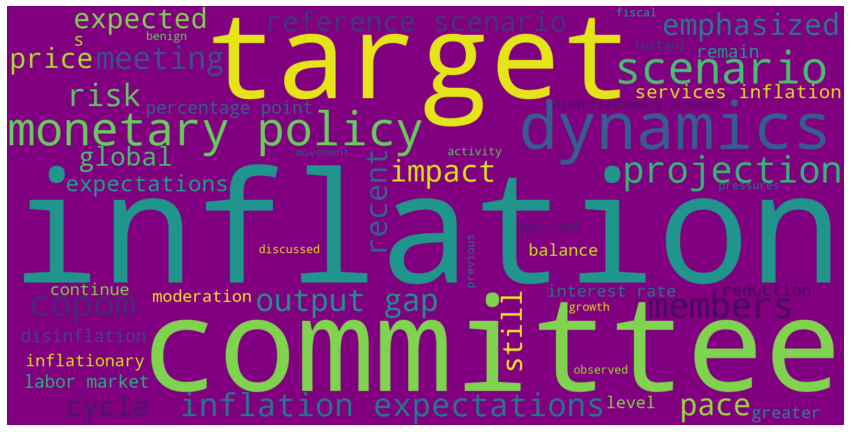

In [37]:
wordcloud_copom(minute_256[0])

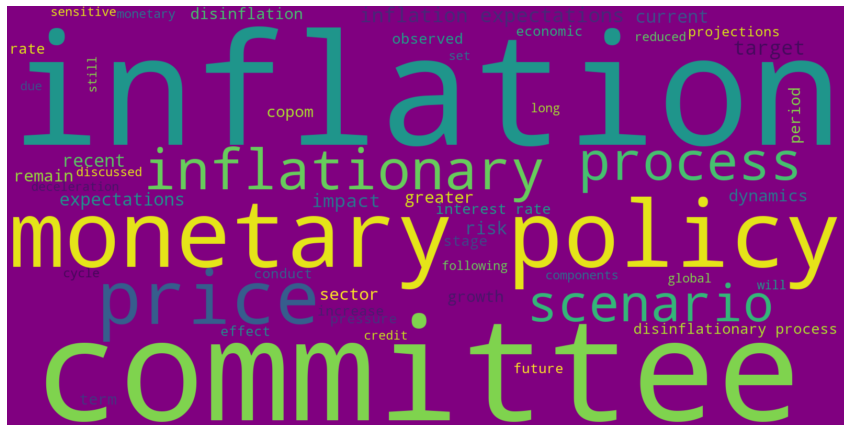

In [38]:
wordcloud_copom(minute_255[0])

#### **Comparação de frases/sentenças entre dois arquivos**

In [48]:
import nltk
from difflib import SequenceMatcher

In [55]:
sentences1 = nltk.sent_tokenize(minute_256[2])
sentences2 = nltk.sent_tokenize(minute_255[2])

# Encontra as sequências comuns
for sentence1 in sentences1:
    for sentence2 in sentences2:
        seq = SequenceMatcher(None, sentence1, sentence2)
        ratio = seq.ratio()
        if ratio > 0.5:  # Define um limiar de similaridade
            print("Sentença do arquivo 1: ", sentence1)
            print("Sentença do arquivo 2: ", sentence2)
            print("Similaridade: ", ratio)
            print()

Sentença do arquivo 1:  4.
Sentença do arquivo 2:  14.
Similaridade:  0.8

Sentença do arquivo 1:  In the reference scenario, the interest rate path is extracted from the Focus survey, and the exchange rate starts at USD/BRL 4.752 and evolves according to the purchasing power parity (PPP).
Sentença do arquivo 2:  In the reference scenario, the interest rate path is extracted from the Focus survey, and the exchange rate starts at USD/BRL 4.852 and evolves according to the purchasing power parity (PPP).
Similaridade:  0.9947643979057592

Sentença do arquivo 1:  The Committee assumes that oil prices follow approximately the futures market curve for the following six months and then start increasing 2% per year onwards.
Sentença do arquivo 2:  The Committee assumes that oil prices follow approximately the futures market curve for the following six months and then start increasing 2% per year onwards.
Similaridade:  1.0

Sentença do arquivo 1:  Moreover, the energy flag is assumed to be “gr

#### **Separando o texto em chunks**

* Thread sobre chunk: https://twitter.com/RLanceMartin/status/1637852940064161792 -> artigo completo: https://lancemartin.notion.site/lancemartin/Lex-GPT-a3ad671766d34f4a9a078da7adf9d382

In [20]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# https://python.langchain.com/en/latest/modules/indexes/text_splitters/examples/character_text_splitter.html

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 100,
    chunk_overlap  = 20,
    length_function = len,
    is_separator_regex = False,
)

text = text_splitter.split_text(minute_255[1])

# O número de chunks criados
len(text)

In [ ]:
text[0]

### **Análise de Sentimento**

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
# https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis?text=Operating+profit+totaled+EUR+9.4+mn+%2C+down+from+EUR+11.7+mn+in+2004+.

In [ ]:
# Modelo pre-treinado escolhido -> https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [17]:
# Criando um função que faz a análise de sentimento.
def sentiment_score(text):
  tokens = tokenizer.encode(text, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits))+1

In [ ]:
# O range do sentimento é entre 1 (pior o sentimento) e 5 (melhor o sentimento).
sentiment_score(minute_256[2])

### **Lendo o arquivo PDF**

* O principal problema de fazer a extração do texto de um arquivo PDF são os textos, palavras e números no rodapé da página.

#### **Transformando o arquivo pdf em txt**

In [ ]:
import os
import io
import pdfminer.high_level
import pdfminer.layout

In [ ]:
def pdf_to_text(pdf_path, txt_path):
    with open(pdf_path, 'rb') as pdf_file:
        with open(txt_path, 'w', encoding='utf-8') as txt_file:
            # Extraia o texto do PDF
            text = pdfminer.high_level.extract_text(pdf_file, laparams=pdfminer.layout.LAParams())

            # Escreva o texto extraído no arquivo TXT
            txt_file.write(text)

# Exemplo de uso
pdf_path = r'C:\Users\vitor\OneDrive\Documentos\Python_B3\Projeto_Copom_Fomc\copom\minutes_253.pdf'
txt_path = r'C:\Users\vitor\OneDrive\Documentos\Python_B3\Projeto_Copom_Fomc\copom\minutes_253.txt'
pdf_to_text(pdf_path, txt_path)